In [55]:
import itertools
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from snowflake.snowpark import Session

# from utilities_time_series import establish_hourly_time_series, create_hourly_df, create_daily_df
from utilities_time_series import create_dataframe, generate_time_series_data

## Create session

In [56]:
session = Session.builder.config("connection_name", "scs").getOrCreate()

In [57]:
session.use_database("ML_FORECASTING")

## Create schema

In [58]:
session.sql("CREATE SCHEMA IF NOT EXISTS MOCKSERIES").collect()

[Row(status='MOCKSERIES already exists, statement succeeded.')]

## Change context

In [59]:
session.use_schema("MOCKSERIES")
print(f"db.schema: {session.get_fully_qualified_current_schema()}")

db.schema: "ML_FORECASTING"."MOCKSERIES"


## User-Defined Parameters

In [60]:
# ==================================================================================================
# ESTABLISH WHAT PARTITIONS WILL BE USED (IF ANY)
# ==================================================================================================
# NOTE: CHANGE to specify zero, one, or multiple partition columns to match their use case

# List of all partition column names followed by a list of the number of unique values for each corresponding partition column
partition_columns = ["STORE_ID", "PRODUCT_ID"]
unique_value_counts = [
    25,
    10,
]  # Multiply all the values in the list to get the total number or partitions in the data set


# ==================================================================================================
# ESTABLISH WHAT EXOGENOUS FEATURES YOU MIGHT WANT TO INCLUDE (IF ANY)
# ==================================================================================================
# NOTE: CHANGE to specify zero, one, or multiple exogenous features to match their use case

exogenous_feature_columns = ["FEATURE_1", "FEATURE_2", "FEATURE_3", "FEATURE_4"]
stddev_scale_factors = [
    2.5,
    5.0,
    10.0,
    750.0,
]  # LOWER numbers (>0) will make features that are MORE correlated with the TARGET


# ==================================================================================================
# SET START YEAR & GRAULARITY (daily, hourly, or weekly).
# ==================================================================================================

# Specify granularity. Example: 'hourly' will generate a time series value at each hour
granularity = "daily"

# Specifying the start year will make the first data point occur on January 1st of that year
start_year = 2021


# ==================================================================================================
# PARAMETER RANGES FOR TIME SERIES FUNCTION
# ==================================================================================================
# NOTE: CHANGE these ranges to adjust qualities of the time series such as trend and seasonality

# Ranges for random generation of parameter values
trend_coeff_range = (-0.75, 0.75)
trend_flat_base_range = (50, 900)
seasonality_daily_amp_range = (2, 15)
seasonality_weekly_amp_range = (2, 25)
seasonality_6mo_amp_range = (15, 40)
seasonality_yearly_amp_range = (15, 50)
noise_mean_range = (0, 0)
noise_std_range = (1, 15)
noise_corr_range = (0.25, 0.65)

## Create separate time series for each of many partitions

In [61]:
# Create a list of lists, where each list is the unique values for the partition column at the corresponding index.
value_lists = []
for i in unique_value_counts:
    value_lists.append(list(range(1, i + 1)))

# Create a list of all possible partition value combinations
all_combos = list(itertools.product(*value_lists))
number_of_partitions = len(all_combos)
print(f"Number of partitions: {number_of_partitions}")

# List to hold each partition's pandas DataFrame
df_list = []

# Loop through partitions and create time series for each partition
for combo in all_combos:
    time_points, ts_values = generate_time_series_data(
        start_year=start_year,
        grain=granularity,
        trend_coeff=random.uniform(*trend_coeff_range),
        trend_flat_base=random.randint(*trend_flat_base_range),
        seasonality_daily_amp=random.randint(*seasonality_daily_amp_range),
        seasonality_weekly_amp=random.randint(*seasonality_weekly_amp_range),
        seasonality_6mo_amp=random.randint(*seasonality_6mo_amp_range),
        seasonality_yearly_amp=random.randint(*seasonality_yearly_amp_range),
        noise_mean=random.randint(*noise_mean_range),
        noise_std=random.randint(*noise_std_range),
        noise_corr=random.uniform(*noise_corr_range),
    )

    df_single_partition = create_dataframe(time_points, ts_values)

    # Add the partition columns to the DataFrame
    if partition_columns:
        for i in range(len(partition_columns)):
            df_single_partition[partition_columns[i]] = combo[i]

    # Add exogenous features that are correlated with the target
    if exogenous_feature_columns:
        target_stddev_hourly = df_single_partition["TARGET"].std()

        for i in range(len(exogenous_feature_columns)):
            df_single_partition[exogenous_feature_columns[i]] = df_single_partition[
                "TARGET"
            ] + np.random.normal(
                loc=0,
                scale=stddev_scale_factors[i] * target_stddev_hourly,
                size=len(df_single_partition),
            )

    # Append the partition's DataFrame to the list
    df_list.append(df_single_partition)

# # Combine all partition DataFrames into a single DataFrame
df_all = pd.concat(df_list, ignore_index=True)

# NOTE: 50,000 partitions took 4.5 minutes to generate and combine into a single DataFrame

Number of partitions: 250


In [62]:
# Look at df
print(df_all.shape)
df_all.head(2)

(367500, 8)


,ORDER_TIMESTAMP,TARGET,STORE_ID,PRODUCT_ID,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4
0,2021-01-01,346.463824,1,1,82.499515,-178.77497,139.206675,-69398.704486
1,2021-01-02,355.593251,1,1,485.130953,967.212542,-587.164441,15568.965378


In [63]:
# Display correlation coefficients between exogenous features and target
print("CORRELATION COEFFICIENT WITH TARGET \n")
for col in exogenous_feature_columns:
    print(f"{col}: {round(df_all['TARGET'].corr(df_all[col]), 3)}")

CORRELATION COEFFICIENT WITH TARGET 

FEATURE_1: 0.872
FEATURE_2: 0.667
FEATURE_3: 0.41
FEATURE_4: 0.006


## Create Snowpark DataFrames 

In [64]:
sdf = session.create_dataframe(df_all)

# NOTE: The pandas df with 50,000 partitions took 18 minutes to turn into a Snowpark df

In [65]:
sdf.describe().to_pandas()

,SUMMARY,TARGET,STORE_ID,PRODUCT_ID,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4
0,count,367500.000000,367500.000000,367500.000000,367500.000000,367500.000000,367500.000000,367500.000000
1,mean,498.183116,13.000000,5.500000,498.349436,498.278172,498.358820,465.937576
2,min,-273.002672,1.000000,1.000000,-809.726087,-1631.191419,-3951.159323,-255665.418523
3,max,1132.556428,25.000000,10.000000,1735.820823,2626.533152,4085.246975,342164.973426
4,stddev,259.755336,7.211112,2.872285,297.672846,389.804080,637.522456,43662.875107


## Write tables to snowflake

In [66]:
sdf.write.save_as_table(
    f"{granularity.upper()}_TS_{number_of_partitions}_PARTITIONS_STARTING_{start_year}",
    mode="overwrite",
)
print(
    f"Created Table: {granularity.upper()}_TS_{number_of_partitions}_PARTITIONS_STARTING_{start_year}"
)

Created Table: DAILY_TS_250_PARTITIONS_STARTING_2021


___

# EXPLORATION

Visualize result of above code

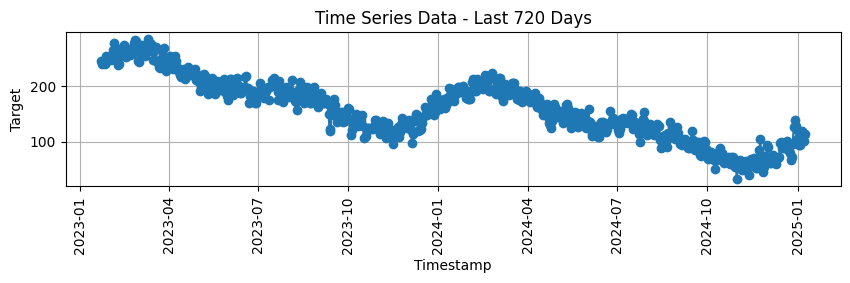

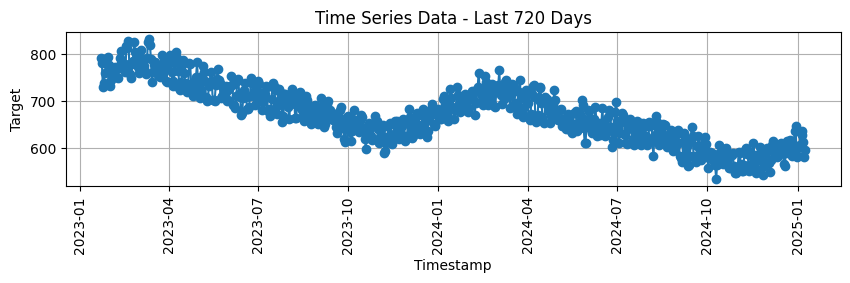

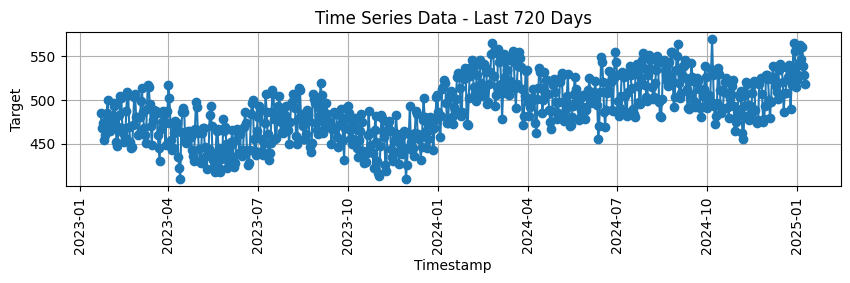

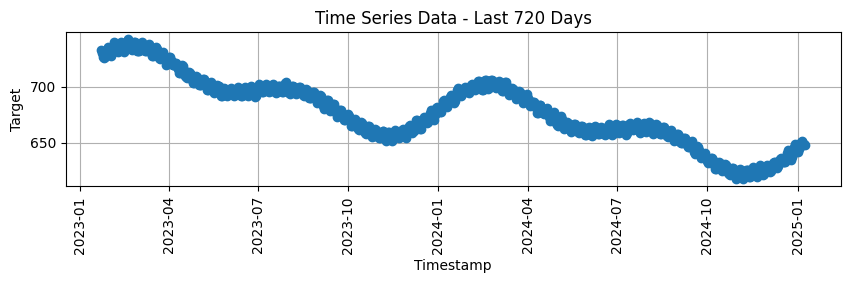

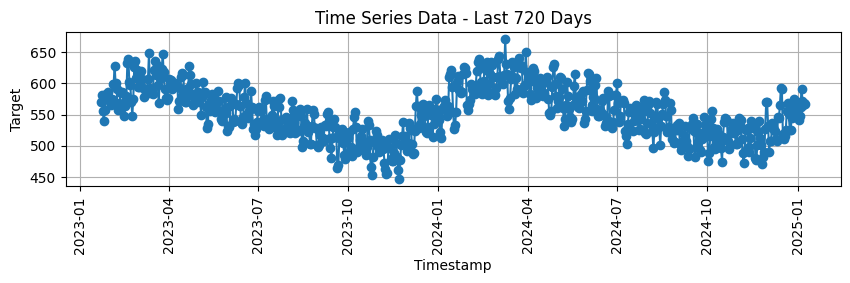

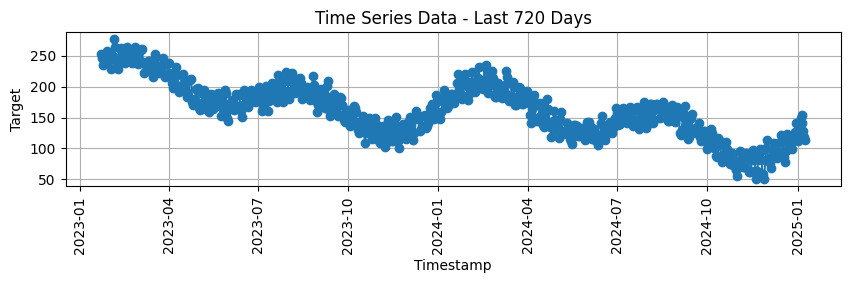

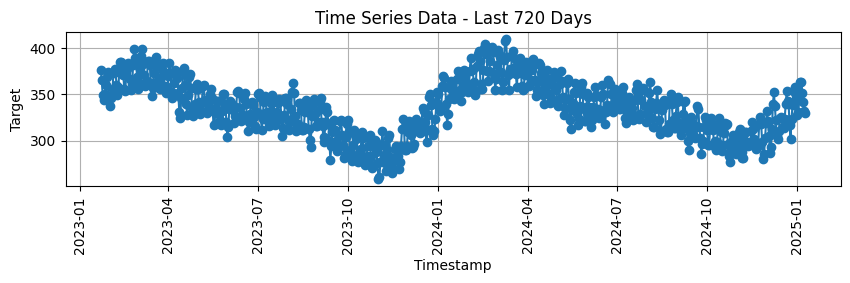

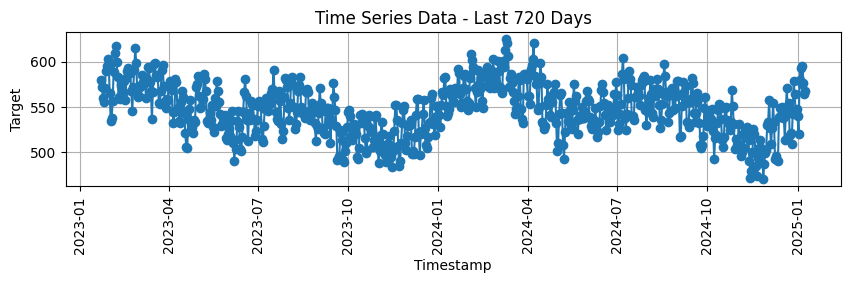

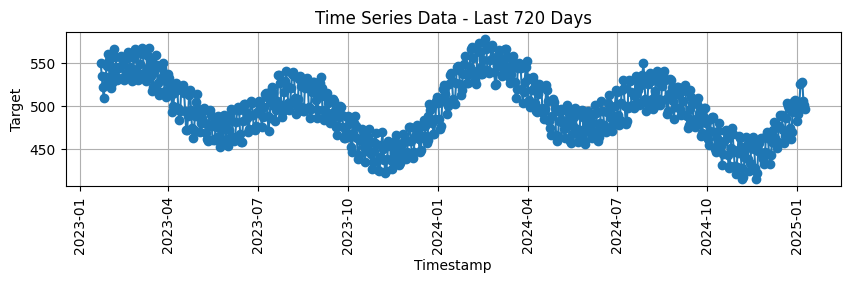

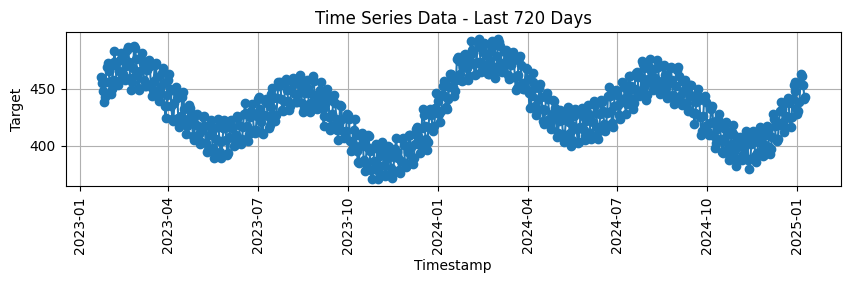

In [67]:
# EXPLORE: Look at plots for different partitions
for combo in all_combos[:10]:
    source_df = df_all
    x = 720  # Number of days to plot

    df = source_df.loc[
        (source_df["STORE_ID"] == combo[0]) & (source_df["PRODUCT_ID"] == combo[1])
    ].copy()
    df.set_index("ORDER_TIMESTAMP", inplace=True)

    recent_x_months = df.loc[df.index >= pd.Timestamp.now() - pd.DateOffset(days=x)]

    plt.figure(figsize=(10, 2))
    plt.plot(
        recent_x_months.index, recent_x_months["TARGET"], marker="o", linestyle="-"
    )
    plt.xlabel("Timestamp")
    plt.ylabel("Target")
    plt.title(f"Time Series Data - Last {x} Days")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

Test out functions to create a time series for a single partition:

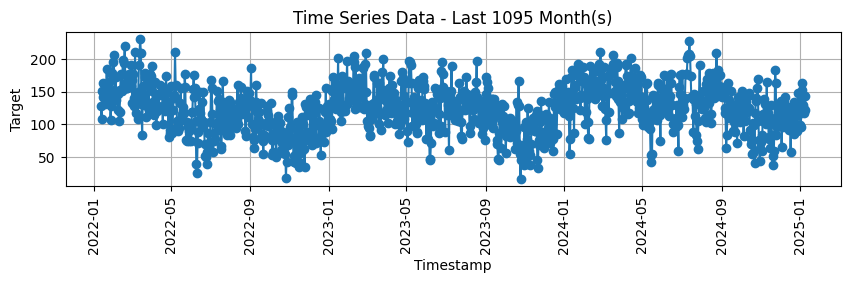

In [68]:
t, v = generate_time_series_data(
    grain="daily",
    trend_coeff=0.1,
    trend_flat_base=100,
    seasonality_daily_amp=5,
    seasonality_weekly_amp=10,
    seasonality_6mo_amp=20,
    seasonality_yearly_amp=25,
    noise_mean=0,
    noise_std=30,
    noise_corr=0.5,
)
d = create_dataframe(t, v)


# VISUALIZATION
df = d.copy()
df.set_index("ORDER_TIMESTAMP", inplace=True)

x = 1095
recent_x_months = df.loc[df.index >= pd.Timestamp.now() - pd.DateOffset(days=x)]

plt.figure(figsize=(10, 2))
plt.plot(recent_x_months.index, recent_x_months["TARGET"], marker="o", linestyle="-")
plt.xlabel("Timestamp")
plt.ylabel("Target")
plt.title(f"Time Series Data - Last {x} Month(s)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

## DEVELOPMENT: Create a single partition fake time series data set with hourly values

In [69]:
# import numpy as np
# from datetime import datetime, timedelta
# from mockseries.trend import LinearTrend
# from mockseries.seasonality import SinusoidalSeasonality
# from mockseries.noise import RedNoise
# from mockseries.utils import datetime_range

In [70]:
# granularity = 'weeks'

In [71]:
# # Establish mock time series with specified trend, seasonality, and noise
# trend = LinearTrend(coefficient= .1, time_unit=timedelta(days=7), flat_base=100)

# seasonality = \
#     SinusoidalSeasonality(amplitude=10, period=timedelta(days=7)) \
#     + SinusoidalSeasonality(amplitude=25, period=timedelta(days=182.5))

# if granularity[0].lower() == 'h':
#     seasonality = seasonality + SinusoidalSeasonality(amplitude=5, period=timedelta(days=1))

# noise = RedNoise(mean=0, std=3, correlation=0.5)

# timeseries = trend + seasonality + noise

# granularity_time_delta = (
#     timedelta(weeks=1) if granularity[0].lower() == 'w'
#     else timedelta(hours=1) if granularity[0].lower() == 'h'
#     else timedelta(days=1)
# )

# time_points = datetime_range(
#     granularity=granularity_time_delta,
#     start_time=datetime(2021, 1, 1),
#     end_time=datetime.today(),
# )
# ts_values = timeseries.generate(time_points=time_points)

# # Create a df at the hourly level
# df_single_partition = pd.DataFrame({"ORDER_TIMESTAMP":time_points,"TARGET":ts_values})

# # Create a df at the daily level
# df = df_single_partition.copy()
# df.set_index('ORDER_TIMESTAMP', inplace=True)
# daily_df = df.resample('D').sum()
# daily_df = daily_df.reset_index()

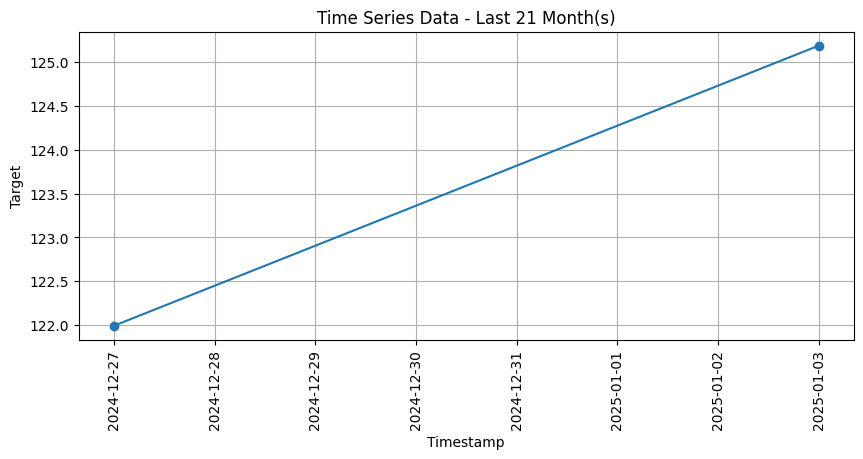

In [ ]:
# # Plot the hourly time series
# df = df_single_partition.copy()
# df.set_index('ORDER_TIMESTAMP', inplace=True)

# x = 21
# recent_x_months = df.loc[df.index >= pd.Timestamp.now() - pd.DateOffset(days=x)]

# plt.figure(figsize=(10, 4))
# plt.plot(recent_x_months.index, recent_x_months['TARGET'], marker='o', linestyle='-')
# plt.xlabel('Timestamp')
# plt.ylabel('Target')
# plt.title(f'Time Series Data - Last {x} Month(s)')
# plt.xticks(rotation=90)
# plt.grid(True)
# plt.show()

In [ ]:
# # EXPLORE is it faster if I use concurrent futures? - NO

# from concurrent.futures import ThreadPoolExecutor, as_completed

# # Create a list of lists, where each list is the unique values for the partition column at the corresponding index.
# value_lists = []
# for i in unique_value_counts:
#     value_lists.append(list(range(1, i + 1)))

# # Create a list of all possible partition value combinations
# all_combos = list(itertools.product(*value_lists))
# number_of_partitions = len(all_combos)
# print(f"Number of partitions: {number_of_partitions}")

# def create_single_partition_ts(combo, partition_columns):

#     """ Create a single partition's time series data and return a DataFrame.

#     Parameters
#     ----------
#     combo :
#         Single combo of partition values.
#     partition_columns : list
#         List of string values representing each of the partition columns.

#     Returns
#     -------
#     pd.DataFrame
#         A pandas DataFrame containing the time points and target values of the time series.

#     """
#     time_points, ts_values = generate_time_series_data(
#         grain = 'daily',
#         trend_coeff = random.uniform(*trend_coeff_range),
#         trend_flat_base = random.randint(*trend_flat_base_range),
#         seasonality_daily_amp = random.randint(*seasonality_daily_amp_range),
#         seasonality_weekly_amp = random.randint(*seasonality_weekly_amp_range),
#         seasonality_6mo_amp = random.randint(*seasonality_6mo_amp_range),
#         seasonality_yearly_amp = random.randint(*seasonality_yearly_amp_range),
#         noise_mean = random.randint(*noise_mean_range),
#         noise_std = random.randint(*noise_std_range),
#         noise_corr = random.uniform(*noise_corr_range)
#     )

#     df_single_partition = create_dataframe(time_points, ts_values)

#     # Add the partition columns to the DataFrame
#     for i in range(len(partition_columns)):
#         df_single_partition[partition_columns[i]] = combo[i]

#     return df_single_partition

# df_list = []

# # Use ThreadPoolExecutor to run the function in parallel
# with ThreadPoolExecutor() as executor:
#     futures = [executor.submit(create_single_partition_ts, combo, partition_columns) for combo in all_combos]

#     # Collect the results
#     for future in as_completed(futures):
#         df = future.result()
#         df_list.append(df)

# # Combine all partition DataFrames into a single DataFrame
# df_all = pd.concat(df_list, ignore_index=True)

Number of partitions: 250
